In [13]:
import pandas as pd
import numpy as np
import os
from collections import OrderedDict
import datetime as dt

In [43]:
# my libraries
from importlib import reload
import pricer
reload(pricer)

<module 'pricer' from '/Users/adammoszczynski/Desktop/research/american option pricing/pricer.py'>

In [8]:
daily_chains = OrderedDict()
files = sorted(os.listdir('spy_data'))

for file in files:
    if file[-4:] == '.csv':
        df = pd.read_csv('spy_data/' + file)        
        
        # moving to datetime and making features
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['quote_date'] = df['quote_datetime'][0].date()
        df['quote_date'] = pd.to_datetime(df['quote_date'])
        
        # getting only 4:00 quotes
        eod = dt.datetime.combine(df['quote_datetime'][0].date(), dt.time(16,0, 0))
        df = df.loc[df['quote_datetime'] == eod]
        
        # getting time to expiration and moneyness
        df['T'] = df['expiration'] - df['quote_date']
        df['T'] = df['T'].dt.days
        
        # filtering for research paper criteria
        df = df.loc[(df['close']!=0) & (df['T'] >= 20) & (df['T'] <= 365)]
                    
        calls = df.loc[df['option_type']=='C'][['quote_date', 'expiration', 'T','implied_volatility', 'active_underlying_price', 'strike', 'bid', 'ask']]
        puts = df.loc[df['option_type']=='P'][['quote_date','expiration', 'T', 'implied_volatility', 'active_underlying_price', 'strike', 'bid', 'ask']]
        
        daily_chains[file[-14:-4]] = {'calls':calls, 'puts':puts}

In [41]:
testday = daily_chains['2023-10-02']
#testday['calls'].iloc[0]['active_underlying_price']


In [44]:
c = testday['calls']
c['my_IV'] = c.apply(lambda row: 
    pricer.derive_IV(row['active_underlying_price'],
                     row['strike'],
                     row['quote_date'],
                     row['expiration'],
                     'call',
                     'curve',
                     [0.003556, 0.25, pricer.time_to_div(row['quote_date'])],
                     (row['bid'] + row['ask']) / 2 ), axis=1)

In [ ]:
p = testday['puts']
p['my_IV'] = p.apply(lambda row: 
    pricer.derive_IV(row['active_underlying_price'],
                     row['strike'],
                     row['quote_date'],
                     row['expiration'],
                     'put',
                     'curve',
                     [0.003556, 0.25, pricer.time_to_div(row['quote_date'])],
                     (row['bid'] + row['ask']) / 2 ), axis=1)

### Plotting

In [71]:
import matplotlib.pyplot as plt

c_surface = c.apply(lambda row: [row['T'], row['strike'], row['my_IV']],axis=1).tolist()
c_surface = np.array(c_surface)

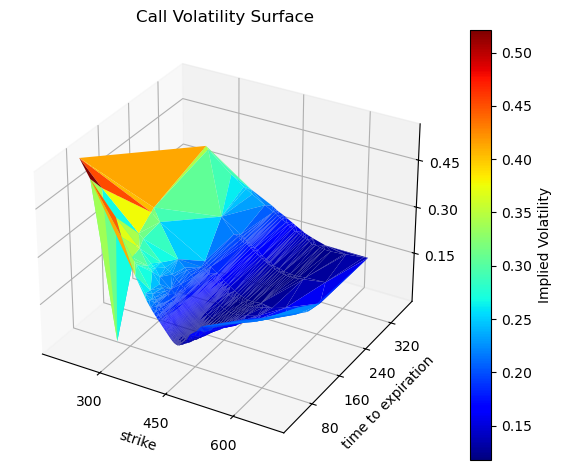

In [78]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Xs = c_surface[:,1]
Ys = c_surface[:,0]
Zs = c_surface[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf, label='Implied Volatility')

ax.set_xlabel('strike')
ax.set_ylabel('time to expiration')

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_title('Call Volatility Surface')

fig.tight_layout()

plt.show() # or: